In [1]:
import numpy as np
import pandas as pd
import mne
import scipy.stats as sp_stats
import scipy.signal as sp_sig
import antropy as ant
from scipy.integrate import simps
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import robust_scale, normalize
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
import joblib
import seaborn as sns
# plt.style.use('dark_background')
pd.options.display.precision = 10

In [2]:
sr = 1000


In [3]:
def bandpower_from_psd_ndarray(psd, freqs, bands, relative=True):
    # Type checks
    assert isinstance(bands, list), 'bands must be a list of tuple(s)'
    assert isinstance(relative, bool), 'relative must be a boolean'

    # Safety checks
    freqs = np.asarray(freqs)
    psd = np.asarray(psd)
    assert freqs.ndim == 1, 'freqs must be a 1-D array of shape (n_freqs,)'
    assert psd.shape[-1] == freqs.shape[-1], 'n_freqs must be last axis of psd'

    # Extract frequencies of interest
    all_freqs = np.hstack([[b[0], b[1]] for b in bands])
    fmin, fmax = min(all_freqs), max(all_freqs)
    idx_good_freq = np.logical_and(freqs >= fmin, freqs <= fmax)
    freqs = freqs[idx_good_freq]
    res = freqs[1] - freqs[0]

    # Trim PSD to frequencies of interest
    psd = psd[..., idx_good_freq]

    # Check if there are negative values in PSD
    if (psd < 0).any():
        msg = (
            "There are negative values in PSD. This will result in incorrect "
            "bandpower values. We highly recommend working with an "
            "all-positive PSD. For more details, please refer to: "
            "https://github.com/raphaelvallat/yasa/issues/29")
        print(msg)

    # Calculate total power
    total_power = simps(psd, dx=res, axis=-1)
    total_power = total_power[np.newaxis, ...]

    # Initialize empty array
    bp = np.zeros((len(bands), *psd.shape[:-1]), dtype=np.float)

    # Enumerate over the frequency bands
    labels = []
    for i, band in enumerate(bands):
        b0, b1, la = band
        labels.append(la)
        idx_band = np.logical_and(freqs >= b0, freqs <= b1)
        bp[i] = simps(psd[..., idx_band], dx=res, axis=-1)

    if relative:
        bp /= total_power
    return bp

def get_metrics(cm):
    if len(cm) == 0:
        cm = np.zeros((2,2), dtype=int)
    if np.squeeze(cm).ndim < 2:
        new_cm = np.zeros((2,2), dtype=int)
        new_cm[1, 1] = int(cm[0][0])
        cm = new_cm
    numerator = cm[0, 0] + cm[1, 1]
    denominator = cm[0, 0] + cm[1, 1] + cm[0, 1] + cm[1, 0]
    accuracy = numerator / denominator
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    numerator = precision * recall
    denominator = (0.25 * precision) + recall
    f_score = 1.25 * numerator / denominator
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f_score': f_score}

In [4]:
def format_raw(edf, channel):
    epochs, epochs_zscore, epochs_random, epochs_index = [], [], [], []
    window_size = int(sr / 4)
    raw = mne.io.read_raw_edf(edf)
    spikes = raw.annotations
    spikes_df = pd.DataFrame(spikes)
    end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
    spikes_df = spikes_df[spikes_df['description'].str.contains(channel[0] + 't')]
    spikes_df = spikes_df.drop_duplicates(subset=['onset'])
    complete_spikes_df = spikes_df[spikes_df['onset'] < end_onset]

    # from first tags round- only some spikes here and there
    random_spikes_df = spikes_df[spikes_df['onset'] > end_onset]
    raw_data = raw.copy().pick_channels([channel]).resample(sr).get_data()[0]
    for onset in random_spikes_df['onset']:
        epochs_random.append(raw_data[int(onset * sr - window_size / 2) : int (onset * sr + window_size / 2)])
        epochs_index.append(int(onset * sr / window_size))
    y_windows_random = np.full(len(epochs_random), 1)

    # from second tags round- complete data
    raw_data = raw.crop(tmax=end_onset).pick_channels([channel]).resample(sr).get_data()[0]

    for i in range(0, len(raw_data), window_size):
        curr_block = raw_data[i: i  + window_size]
        if i + window_size < len(raw_data):
            epochs.append(curr_block)
            #epochs_zscore.append(curr_block / np.sqrt(np.sum(curr_block**2)))

    y_windows = np.zeros(len(epochs))
    for onset in complete_spikes_df['onset']:
        y_windows[int(onset * 1000 / window_size)] = 1
    
    final_index = np.concatenate((np.arange(len(epochs)), epochs_index))
    epochs = np.concatenate((epochs, epochs_random))
    y_windows = np.concatenate((y_windows, y_windows_random))
        
    return np.array(epochs), np.array(epochs_zscore), y_windows, final_index

In [5]:
def calc_features(epochs):
    # Bandpass filter
    freq_broad = (0.1, 500)
    # FFT & bandpower parameters
    sr = 1000
    bands = [
        (0.1, 4, 'delta'), (4, 8, 'theta'),
        (8, 12, 'alpha'), (12, 16, 'sigma'), (16, 30, 'beta'),
        (30, 100, 'gamma'), (100, 300, 'fast')
    ]

    # Calculate standard descriptive statistics
    hmob, hcomp = ant.hjorth_params(epochs, axis=1)

    feat = {
        'std': np.std(epochs, ddof=1, axis=1),
        'iqr': sp_stats.iqr(epochs, axis=1),
        'skew': sp_stats.skew(epochs, axis=1),
        'kurt': sp_stats.kurtosis(epochs, axis=1),
        'nzc': ant.num_zerocross(epochs, axis=1),
        'hmob': hmob,
        'hcomp': hcomp
    }

    # Calculate spectral power features (for EEG + EOG)
    freqs, psd = sp_sig.welch(epochs, sr)
    bp = bandpower_from_psd_ndarray(psd, freqs, bands=bands)
    for j, (_, _, b) in enumerate(bands):
        feat[b] = bp[j]

    # Add power ratios for EEG
    delta = feat['delta']
    feat['dt'] = delta / feat['theta']
    feat['ds'] = delta / feat['sigma']
    feat['db'] = delta / feat['beta']
    feat['dg'] = delta / feat['gamma']
    feat['df'] = delta / feat['fast']
    feat['at'] = feat['alpha'] / feat['theta']
    feat['gt'] = feat['gamma'] / feat['theta']
    feat['ft'] = feat['fast'] / feat['theta']
    feat['ag'] = feat['gamma'] / feat['alpha']
    feat['af'] = feat['fast'] / feat['alpha']

    # Add total power
    idx_broad = np.logical_and(
        freqs >= freq_broad[0], freqs <= freq_broad[1])
    dx = freqs[1] - freqs[0]
    feat['abspow'] = np.trapz(psd[:, idx_broad], dx=dx)

    # Calculate entropy and fractal dimension features
    feat['perm'] = np.apply_along_axis(
        ant.perm_entropy, axis=1, arr=epochs, normalize=True)
    feat['higuchi'] = np.apply_along_axis(
        ant.higuchi_fd, axis=1, arr=epochs)
    feat['petrosian'] = ant.petrosian_fd(epochs, axis=1)

    # Convert to dataframe
    feat = pd.DataFrame(feat)
    feat.index.name = 'epoch'

    #############################
    # SMOOTHING & NORMALIZATION
    #############################
    roll1 = feat.rolling(window=1, center=True, min_periods=1, win_type='triang').mean()
    roll1[roll1.columns] = robust_scale(roll1, quantile_range=(5, 95))
    roll1 = roll1.add_suffix('_cmin_norm')

    roll3 = feat.rolling(window=3, center=True, min_periods=1, win_type='triang').mean()
    roll3[roll3.columns] = robust_scale(roll3, quantile_range=(5, 95))
    roll3 = roll3.add_suffix('_pmin_norm')

    # Add to current set of features
    feat = feat.join(roll1).join(roll3)
    # Remove cols of only zeros
    feat = feat.loc[:, (feat != 0).any(axis=0)]
    
    return feat

In [6]:
def run_all():
    x_all = np.empty((0, 250))
    x_all_zscore = np.empty((0, 250))
    y_all = np.empty(0)
    for subj in ['396', '398', '402', '406', '415', '416']:
        for side in ['R', 'L']:
            if not (subj == '396' and side == 'R'):
#                 x, x_zscore, y = format_raw(f'/Users/rotemfalach/Documents/University/lab/Lilach_new/{subj}_for_tag.edf', side)
                x, x_zscore, y, x_index = format_raw(f'C:\\Lilach\\{subj}_for_tag_filtered_fix_tag.edf', side)
                x_all = np.concatenate((x_all, x))
#                 x_all_zscore = np.concatenate((x_all_zscore, x_zscore))
                y_all = np.concatenate((y_all, y))
    return x_all, x_all_zscore, y_all

def run_all_multi_channel():
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    x_all = np.empty((0, 250))
    y_all = np.empty(0)
    feat_all = pd.DataFrame()
    for subj in ['396', '398', '402', '406', '415', '416']:
        # for subj in ['398']:
        for channel in ['RAH1', 'LAH1']:
            if not (subj == '396' and channel == 'RAH1'):
                x, x_zscore, y, x_index = format_raw(f'C:\\Lilach\\{subj}_for_tag_filtered_fix_tag.edf', channel)
                x_all = np.concatenate((x_all, x))
                y_all = np.concatenate((y_all, y))
                features = calc_features(x)
                for neighbor in neighbors[channel[0]]:
                    x, x_zscore, y, x_index = format_raw(f'C:\\Lilach\\{subj}_for_tag_filtered_fix_tag.edf', neighbor)
                    prefix = neighbor.replace(channel[0], '')
                    features_neighbor = calc_features(x).add_prefix(f'{prefix}_')
                    features = pd.concat([features, features_neighbor], axis=1)

                feat_all = pd.concat([feat_all, features], axis=0)

    return x_all, feat_all, y_all

def run_all_multi_channel_with_x_neighbor():
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    x_AH = np.empty((0, 250))
    x_A = np.empty((0, 250))
    x_bi = np.empty((0, 250))
    y_all = np.empty(0)
    feat_all = pd.DataFrame()
    for subj in ['396', '398', '402', '406', '415', '416']:
        # for subj in ['398']:
        for channel in ['RAH1', 'LAH1']:
            if not (subj == '396' and channel == 'RAH1'):
                x, x_zscore, y, x_index = format_raw(f'C:\\Lilach\\{subj}_for_tag_filtered_fix_tag.edf', channel)
                x_AH = np.concatenate((x_AH, x))
                y_all = np.concatenate((y_all, y))
                features = calc_features(x)
                for neighbor in neighbors[channel[0]]:
                    x, x_zscore, y, x_index = format_raw(f'C:\\Lilach\\{subj}_for_tag_filtered_fix_tag.edf', neighbor)
                    if '-' in neighbor:
                        x_bi = np.concatenate((x_bi, x))
                    else:
                        x_A = np.concatenate((x_A, x))
                    prefix = neighbor.replace(channel[0], '')
                    features_neighbor = calc_features(x).add_prefix(f'{prefix}_')
                    features = pd.concat([features, features_neighbor], axis=1)

                feat_all = pd.concat([feat_all, features], axis=0)

    return x_AH, x_bi, x_A, feat_all, y_all

In [7]:
def run_one():
    subj = '416'
    side = 'R'
    #     x, x_zscore, y, x_index = format_raw(f'/Users/rotemfalach/Documents/University/lab/Lilach_new/{subj}_for_tag.edf', side)
    x_all, x_all_zscore, y_all, x_index = format_raw(f'C:\\Lilach\\{subj}_for_tag_filtered.edf', side)
    #     x_all_zscore = np.concatenate((x_all_zscore, x_zscore))
    return x_all, x_all_zscore, y_all

In [8]:
# x_all, x_all_zscore, y_all = run_all()
# # x_all, x_all_zscore, y_all = run_one()
# feat_all = calc_features(x_all)
# # feat_all['epoch'] = x_index
# # feat_all_zscore = calc_features(x_all_zscore)

In [9]:
x_AH, x_bi, x_A, feat_all, y_all = run_all_multi_channel_with_x_neighbor()
from IPython.display import clear_output
clear_output()

In [10]:
# Feature selection stuff
all_col = feat_all.columns
selector = VarianceThreshold(.1)
selector.fit_transform(feat_all)
feat_all = feat_all[feat_all.columns[selector.get_support(indices=True)]]

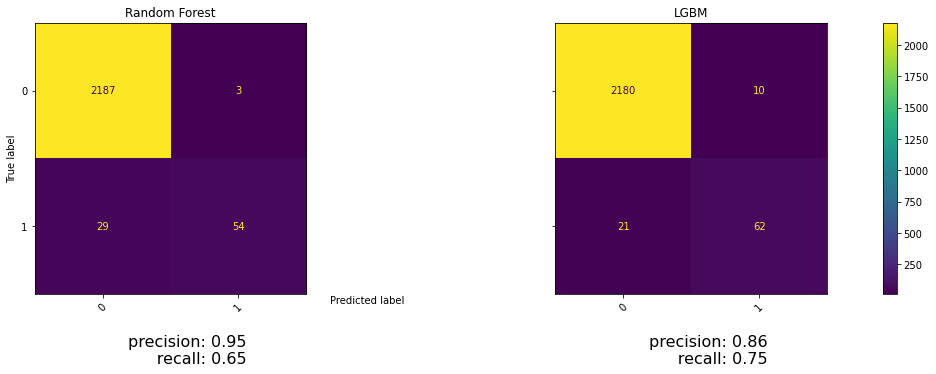

In [11]:
X_train, X_test, y_train, y_test = train_test_split(feat_all, y_all, stratify=y_all, random_state=30)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
#     "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    text = """precision: {0}
              recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                xytext=(-60, -40), textcoords='offset points',
                ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

In [11]:
# # all tags (for qa)
# i_all = feat_all[y_all == 1].sort_values(by='epoch').index.tolist()
# for i in i_all:
#     plt.figure()
#     plt.title(i)
#     pred_view = np.concatenate(x_all[i - 4: i + 5])
#     plt.plot(pred_view)
#     plt.plot(range(1000, 1250), x_all[i], c='fuchsia')

In [ ]:
# i_train = X_train[y_train == 1].sort_values(by='epoch').index.tolist()
# for i in i_train:
#     plt.figure()
#     plt.title(i)
#     pred_view = np.concatenate(x_all[i - 4: i + 5])
#     plt.plot(pred_view)
#     plt.plot(range(1000, 1250), x_all[i], c='yellowgreen')

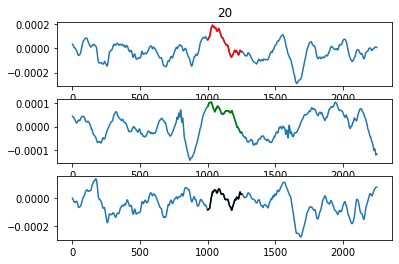

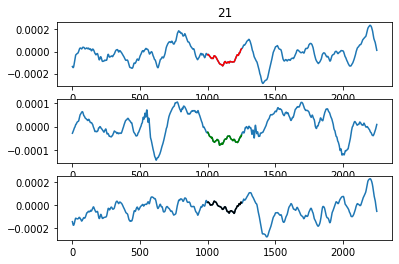

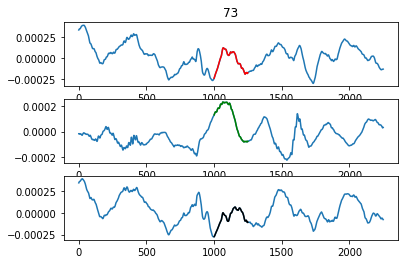

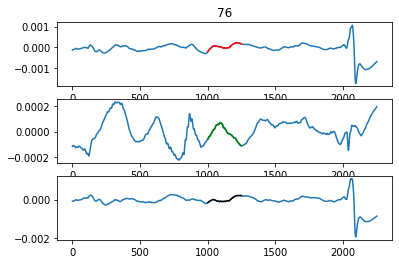

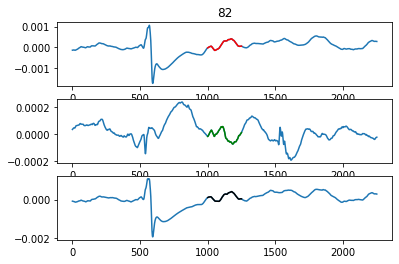

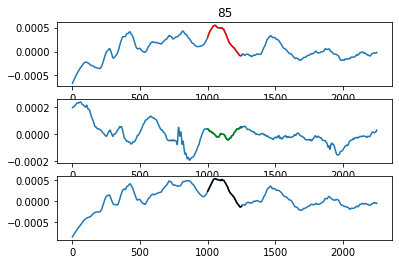

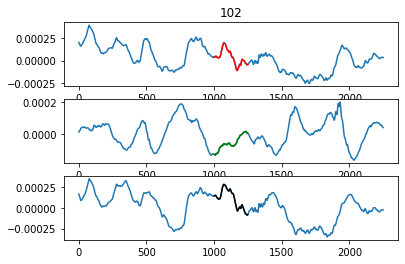

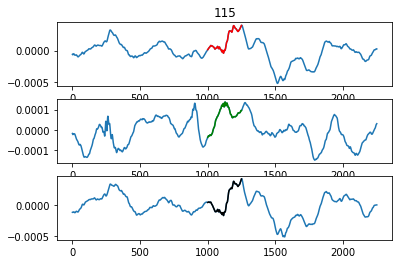

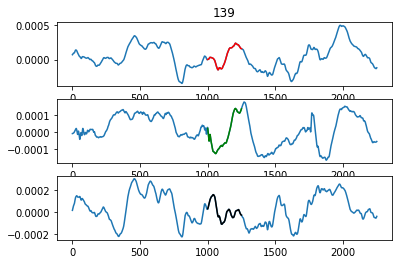

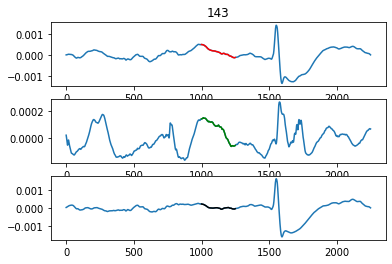

In [16]:
i_pred = X_test[y_pred == 1].sort_values(by='epoch').index.tolist()
for i in i_pred[:10]:
    fig, axs = plt.subplots(3)
    axs[0].set_title(i)
    pred_view = np.concatenate(x_AH[i - 4: i + 5])
    axs[0].plot(pred_view)
    axs[0].plot(range(1000, 1250), x_AH[i], c='red')
    pred_view = np.concatenate(x_A[i - 4: i + 5])
    axs[1].plot(pred_view)
    axs[1].plot(range(1000, 1250), x_A[i], c='green')
    pred_view = np.concatenate(x_bi[i - 4: i + 5])
    axs[2].plot(pred_view)
    axs[2].plot(range(1000, 1250), x_bi[i], c='black')

Int64Index([ 20,  21,  37,  73,  76,  82,  86, 101, 102, 115, 139, 143, 145,
            156, 157, 159, 171, 213, 252, 270, 305, 323, 350, 370, 371, 390,
            455, 488, 489, 572, 576, 586, 594, 601, 647, 682, 694, 754, 760,
            773, 777, 777, 777, 778, 780, 782, 783, 783, 784, 785, 787, 789,
            790, 803, 805, 806, 807, 808, 809, 814, 827, 830, 832, 834, 913,
            916, 921, 922, 923],
           dtype='int64', name='epoch')

In [18]:
# save model to file
# model_file = 'lgbm_model_multichannel.pkl'
# joblib.dump(classifiers['LGBM'], model_file)

model_file = 'forest.pkl'
joblib.dump(classifiers['Random Forest'], model_file)

['forest.pkl']

In [19]:
# import csv
#
# with open('features.csv', 'w') as file:
#     wr = csv.writer(file, quoting=csv.QUOTE_ALL)
#     wr.writerow(feat_all.columns.tolist())

cols_df = feat_all.drop(feat_all[:].index)
cols_df.to_csv('features_forest.csv')

,skew,kurt,nzc,hcomp,at,gt,ag,af,std_cmin_norm,iqr_cmin_norm,...,A1_beta_pmin_norm,A1_gamma_pmin_norm,A1_fast_pmin_norm,A1_at_pmin_norm,A1_gt_pmin_norm,A1_ft_pmin_norm,A1_ag_pmin_norm,A1_af_pmin_norm,A1_abspow_pmin_norm,A1_perm_pmin_norm
epoch,,,,,,,,,,,,,,,,,,,,,


In [75]:
feat_y = feat_all
feat_y['y'] = y_all
cor = feat_y.corr()
cor

,skew,kurt,nzc,hcomp,at,gt,ag,af,std_cmin_norm,iqr_cmin_norm,...,A1_gamma_pmin_norm,A1_fast_pmin_norm,A1_at_pmin_norm,A1_gt_pmin_norm,A1_ft_pmin_norm,A1_ag_pmin_norm,A1_af_pmin_norm,A1_abspow_pmin_norm,A1_perm_pmin_norm,y
skew,1.0000000000,0.0083287505,0.0208829328,0.0032197219,-0.0093967990,-0.0130105296,-0.0346816804,-0.0114458667,0.0404509879,0.0078351054,...,0.0077117861,0.0158607000,0.0009552196,-0.0071435452,0.0006575161,-0.0039209564,0.0041198445,0.0511226047,-0.0108018231,0.0445046244
kurt,0.0083287505,1.0000000000,0.1041042500,-0.2322130759,0.1920543456,0.1288938784,0.1070287068,0.0312198922,0.0653720465,-0.1357007555,...,0.0804232172,0.0400882475,0.0965420795,0.0424393052,0.0361578042,0.0226563810,0.0097868654,0.1010853493,-0.0121027098,0.2539404864
nzc,0.0208829328,0.1041042500,1.0000000000,-0.1296998899,0.1744604365,0.1586971116,0.1273146672,0.0954538923,-0.1067519629,-0.1300015838,...,0.1030990937,0.0609969367,0.0815229167,0.0737704993,0.0596577515,0.0456770056,0.0280376099,-0.0147537223,0.0851166466,0.0083541986
hcomp,0.0032197219,-0.2322130759,-0.1296998899,1.0000000000,-0.2085974314,-0.1122170815,-0.0754750797,-0.0160150006,0.1878037533,0.2895093437,...,-0.1478315111,-0.1039056176,-0.1668311674,-0.0799339072,-0.0836467736,-0.0494608651,-0.0405727201,-0.0181456216,-0.2132223436,-0.1249803087
at,-0.0093967990,0.1920543456,0.1744604365,-0.2085974314,1.0000000000,0.4211414417,-0.0034831380,-0.0065489122,-0.0742111132,-0.1257840782,...,0.0297680525,0.0150010296,0.2206657504,0.0296801321,0.0313172514,0.0044839090,-0.0006880652,0.0367684796,0.0434247221,0.0654354304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A1_ag_pmin_norm,-0.0039209564,0.0226563810,0.0456770056,-0.0494608651,0.0044839090,0.1796335677,0.0802775094,0.0412891901,-0.0369426597,-0.0453304467,...,0.5161463977,0.3148705629,-0.0304801288,0.3984831827,0.3201099521,1.0000000000,0.8697521402,-0.0370292863,0.1081522753,-0.0120238887
A1_af_pmin_norm,0.0041198445,0.0097868654,0.0280376099,-0.0405727201,-0.0006880652,0.0455851976,0.0367736549,0.0315000099,-0.0535135226,-0.0572555281,...,0.3948161542,0.5186084109,-0.0423433563,0.2187205330,0.3710236802,0.8697521402,1.0000000000,-0.0446955501,0.1352341187,-0.0243021217
A1_abspow_pmin_norm,0.0511226047,0.1010853493,-0.0147537223,-0.0181456216,0.0367684796,-0.0115396581,-0.0250467095,-0.0138502870,0.5865961029,0.3975011724,...,-0.1049633946,-0.1162522309,0.0299679368,-0.0336394940,-0.0723983026,-0.0370292863,-0.0446955501,1.0000000000,-0.3336270893,0.4626939106
A1_perm_pmin_norm,-0.0108018231,-0.0121027098,0.0851166466,-0.2132223436,0.0434247221,0.0527796113,0.0545845839,0.0347948069,-0.3841532007,-0.3803349280,...,0.3139776028,0.3390395715,0.1002248815,0.1389301059,0.2247916849,0.1081522753,0.1352341187,-0.3336270893,1.0000000000,-0.2363257006


In [89]:
max_cor = cor[cor > 0.5]
max_cor = max_cor[max_cor.isnull().sum(axis=1) != max_cor.shape[0] - 1]
max_cor

,skew,kurt,nzc,hcomp,at,gt,ag,af,std_cmin_norm,iqr_cmin_norm,...,A1_gamma_pmin_norm,A1_fast_pmin_norm,A1_at_pmin_norm,A1_gt_pmin_norm,A1_ft_pmin_norm,A1_ag_pmin_norm,A1_af_pmin_norm,A1_abspow_pmin_norm,A1_perm_pmin_norm,y
kurt,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nzc,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hcomp,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
at,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gt,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A1_ag_pmin_norm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.5161463977,NaN,NaN,NaN,NaN,1.0000000000,0.8697521402,NaN,NaN,NaN
A1_af_pmin_norm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.5186084109,NaN,NaN,NaN,0.8697521402,1.0000000000,NaN,NaN,NaN
A1_abspow_pmin_norm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5865961029,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
A1_perm_pmin_norm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


<AxesSubplot:>

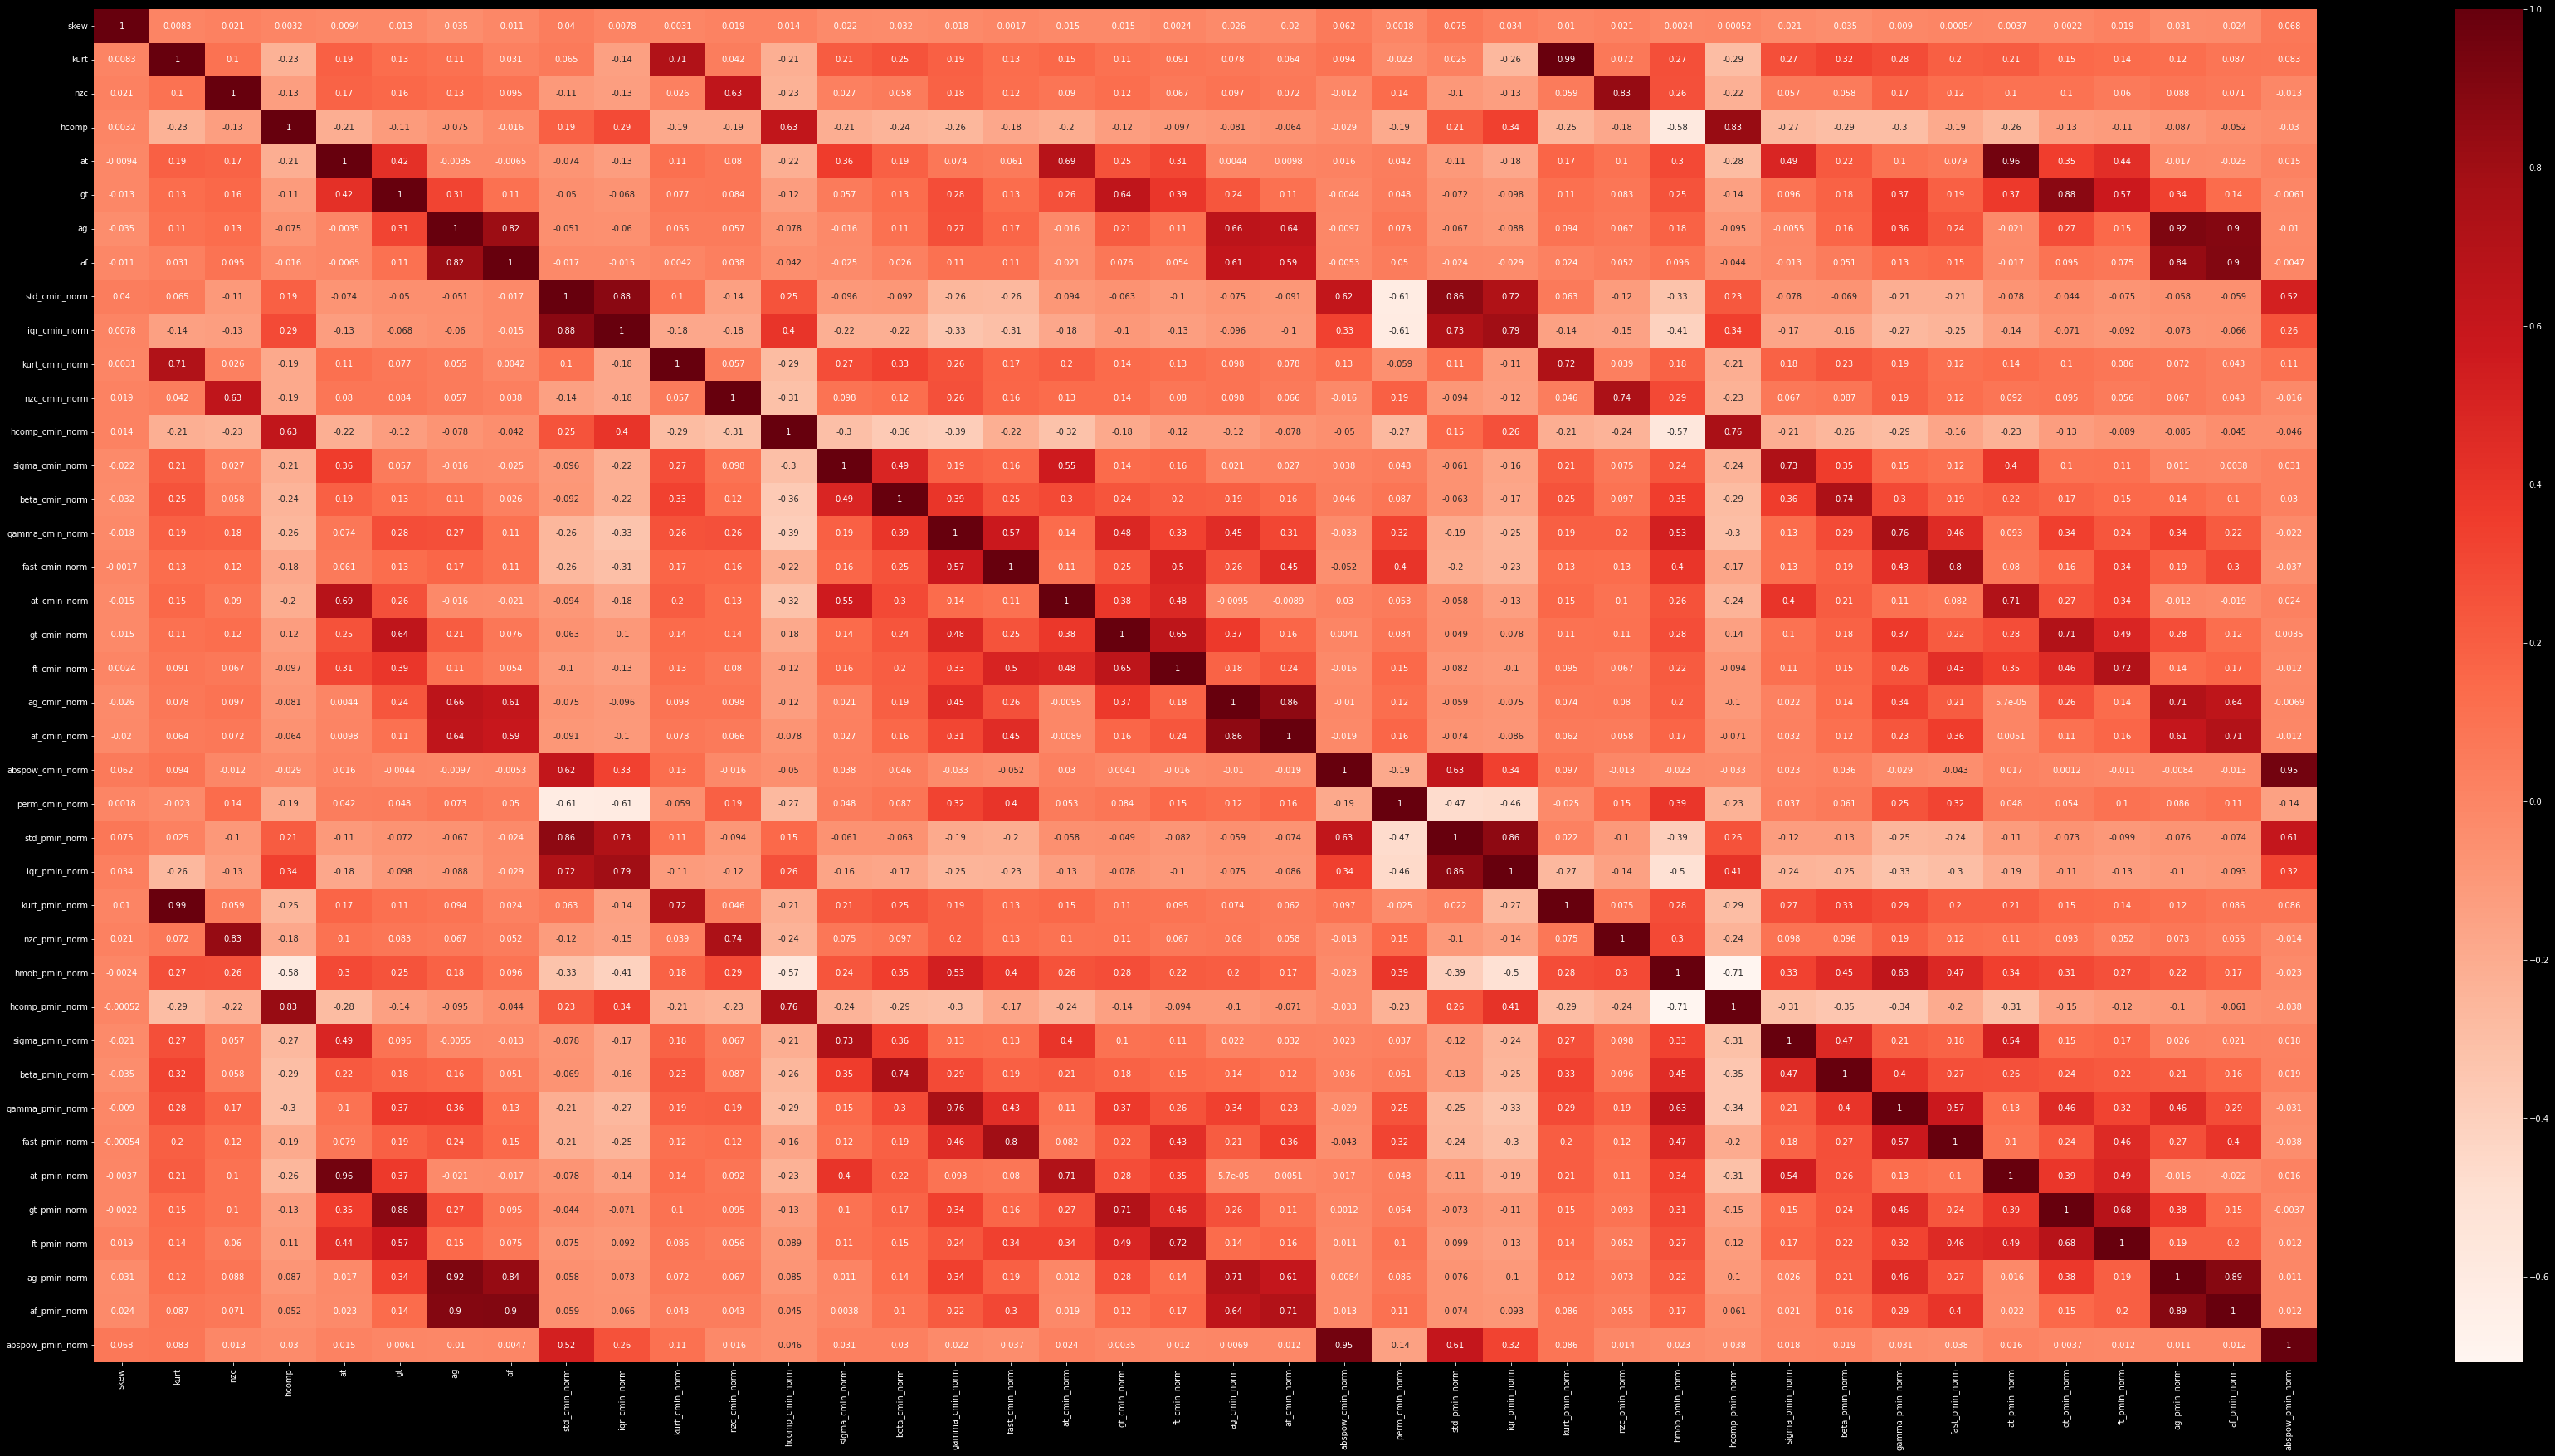

In [76]:
plt.rcParams['figure.figsize'] = (60, 30)
sns.heatmap(cor.iloc[:40, :40], annot=True, cmap=plt.cm.Reds)

<BarContainer object of 10 artists>

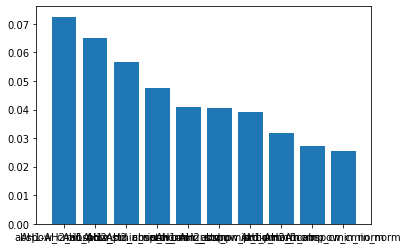

In [40]:
imp = cols_df.T
imp['imp'] = classifiers['Random Forest'].feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(10)['imp'].values
plt.bar(imp.head(10).index, imp.head(10)['imp'].values)

In [41]:
imp.head(10).index

Index(['abspow_cmin_norm', 'AH1-AH2_abspow_pmin_norm', 'AH1-AH2_std_cmin_norm',
       'AH1-AH2_abspow_cmin_norm', 'std_cmin_norm', 'AH1-AH2_std_pmin_norm',
       'abspow_pmin_norm', 'std_pmin_norm', 'AH1-AH2_hcomp_cmin_norm',
       'A1_abspow_cmin_norm'],
      dtype='object')

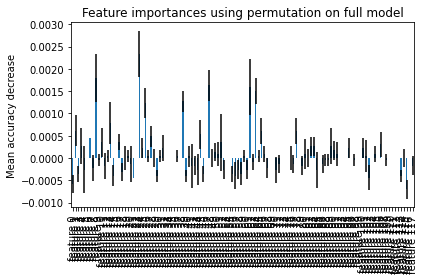

In [23]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    classifiers['Random Forest'], X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)


forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [25]:
pd.DataFrame(classifiers['Random Forest'].feature_importances_)


,0
0,0.0067523343
1,0.0175428098
2,0.0016170536
3,0.0105244243
4,0.0072585845
...,...
113,0.0023539418
114,0.0024604866
115,0.0040358237
116,0.0154212369
